In [1]:
import yaml
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from datasets import BCDataDataset, PointsToGaussianHeatmap, PointsToGaussianHeatmapFast, collate_heatmap_points
from visualization import overlay_heatmap

import torch
from torch.utils.data import DataLoader

from models import NucleusLocalizationModel, heatmap_weighted_mse_loss
from src import heatmaps_to_points_batch
from tqdm import tqdm


In [2]:
with open("config.yaml", "r") as f:
    cfg = yaml.safe_load(f)


data_root = Path(cfg["paths"]["data_root"])
print(data_root)

/home/yeldos/Istanbul/obsidian_vault/work_AITU/IHC/DATASETS/BCData


In [ ]:
heatmap_generator = PointsToGaussianHeatmap(out_hw=(160,160), in_hw=(640,640), sigma=2.0)
dataset = BCDataDataset(root = data_root,
                        split="validation",
                        target_transform = heatmap_generator)

(np.float64(-0.5), np.float64(639.5), np.float64(639.5), np.float64(-0.5))

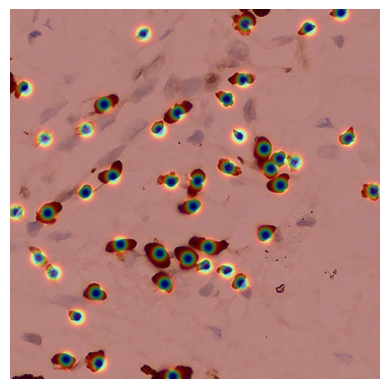

In [4]:
import cv2


img, heatmap, pts = dataset[1]
img_np = img.permute(1, 2, 0).cpu().numpy()   # HWC
hm_np  = heatmap.squeeze(0).cpu().numpy()    # HW

overlay = overlay_heatmap(img_np, hm_np)

#plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.imshow(overlay)
plt.axis("off")


(np.float64(-0.5), np.float64(639.5), np.float64(639.5), np.float64(-0.5))

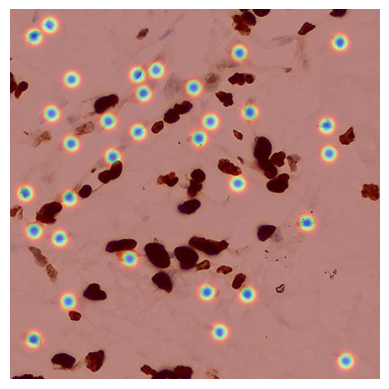

In [5]:
import cv2


img, heatmap, pts = dataset[1]
img_np = img.permute(1, 2, 0).cpu().numpy()   # HWC
hm_np  = heatmap.squeeze(0).cpu().numpy()    # HW

overlay = overlay_heatmap(img_np, hm_np)

#plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.imshow(overlay)
plt.axis("off")


In [5]:
val_loader = DataLoader(
    dataset,
    batch_size=4,        # choose based on GPU memory (640×640 images are large)
    shuffle=False,
    num_workers=0,       # use 0 if debugging
    pin_memory=True,     # recommended when using GPU
    drop_last=True,       # optional, useful for BatchNorm
    collate_fn = collate_heatmap_points
)

In [2]:
model = NucleusLocalizationModel()



In [3]:

trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad
)

print(f"Trainable parameters: {trainable_params:,}")

Trainable parameters: 25,662,273


In [ ]:
model.load_state_dict(torch.load("checkpoints/100eps.pt"))
model.eval()

In [7]:
device = 'cuda'
model.to(device)

true_n = []
found_n = []
for imgs, heatmaps, pts in tqdm(val_loader):
    #print(img.shape)
    #print(heatmap.shape)
    #print(len(pts[0]))

    B = len(pts)

    imgs = imgs.to(device, non_blocking=True)
    heatmaps = heatmaps.to(device, non_blocking=True)
    preds = model(imgs)



    rec_ps = heatmaps_to_points_batch(preds, sigma = 2.0)

    for i in range(B):
        true_n.append(len(pts[i]))
        found_n.append(len(rec_ps[i]))

100%|██████████| 33/33 [00:09<00:00,  3.45it/s]


In [17]:
true_n_mean = np.mean(true_n)
found_n_mean = np.mean(found_n)

sum_of_xty = 0.
sum_of_xsqrd = 0.
sum_of_ysqrd = 0.

sample_size = len(true_n)
print(sample_size)

abs_error = []
sqr_error = []
perc_error = []
for i in range(len(true_n)):
    tmp = np.abs(found_n[i] - true_n[i])
    abs_error.append(tmp)
    sqr_error.append(tmp**2)

    tmp = tmp / true_n[i]
    perc_error.append(tmp)


    sum_of_xty += (true_n[i] * found_n[i])
    sum_of_xsqrd += (true_n[i] * true_n[i])
    sum_of_ysqrd += (found_n[i] * found_n[i])


132


In [16]:
print(sum_of_xty)
print(sum_of_xsqrd)
print(sum_of_ysqrd)

697367.0
729423.0
677220.0


In [20]:
r = np.corrcoef(true_n, found_n)[0, 1]
print(r)

0.9809827052531316


In [5]:
!nvidia-smi

Mon Jan 26 17:38:36 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.126.09             Driver Version: 580.126.09     CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   56C    P0             14W /   60W |      95MiB /   4096MiB |     30%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----